c:\Users\alice\apps\burise\spectral-analysis-comparison\spectral_decomposition\__init__.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Combined signal mean: -1.0435227333852937
Freq range: 0.0 to 490.0


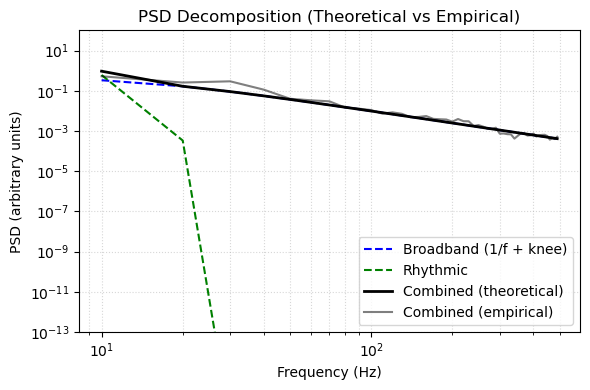

In [7]:
# Simulate data

from spectral_decomposition import spectrum

res = spectrum(
    sampling_rate=1000,
    duration=0.1,
    aperiodic_exponent=2.0,
    aperiodic_offset=2.0,
    knee=200,
    peaks=[{'freq':12, 'amplitude': 1.0, 'sigma': 2.0}],
    average_firing_rate=0.0,
    random_state=42,
    direct_estimate=True,
    plot=True
)

# Access time-domain signals
td = res.time_domain
print("Combined signal mean:", td.combined_signal.mean())

# Access freq-domain data
fd = res.frequency_domain
print("Freq range:", fd.frequencies[0], "to", fd.frequencies[-1])

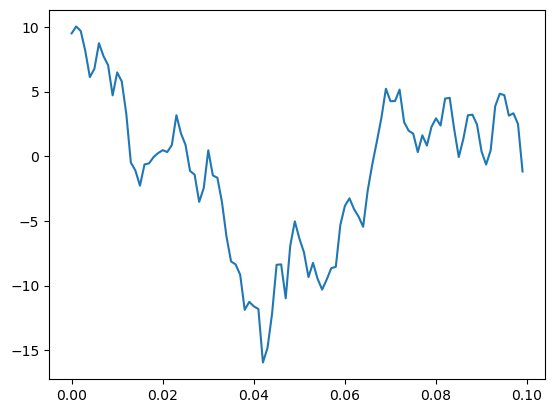

In [8]:
# This is what the signal looks like!

import matplotlib.pyplot as plt

signal = td.combined_signal
time = td.time

plt.plot(time, signal)
plt.show()

In [9]:
# Single taper

from scipy.signal import welch

def single_taper_psd(signal, window, fs=1000, window_length=None, overlap=0):
    N = len(signal)
    nperseg = N if window_length is None else int(window_length * fs) # number of samples per segment
    noverlap = int(nperseg * overlap) # number of samples per overlap

    freqs, psd = welch(signal,
                       fs=fs,
                       window=window,
                       nperseg=nperseg,
                       noverlap=noverlap,
                       scaling='density' # return psd
                       )

    return freqs, psd

In [10]:
# Multitaper (not yet scaled)
import numpy as np
from scipy.signal.windows import dpss
from scipy.fft import fft, fftfreq

def multitaper_psd(signal, fs=1000, NW=2, K=None): # only TW and Window length
    N = len(signal)  

    # deafult to 2*NW - 1 tapers
    K = K or int(2 * NW - 1)

    # create dpss tapers
    tapers = dpss(N, NW, K)  # shape: (K, N)

    # Apply each taper to the signals
    
    tapered_signals = np.array([np.abs(fft(signal * taper)) ** 2 / (fs * N * (1/N * np.sum(tapers ** 2))) for taper in tapers])  # divide by Welch normalization factor U = 1/L * Σ w(n)^2

    fft_sum = np.sum(tapered_signals, axis=0) # summed PSD across taper

    psd = fft_sum / K  # Average PSD
    freqs = fftfreq(N, d=1/fs)

    return freqs[freqs >= 0], 2*psd[freqs >= 0] # only want positive frequencies

In [11]:
# Normalization

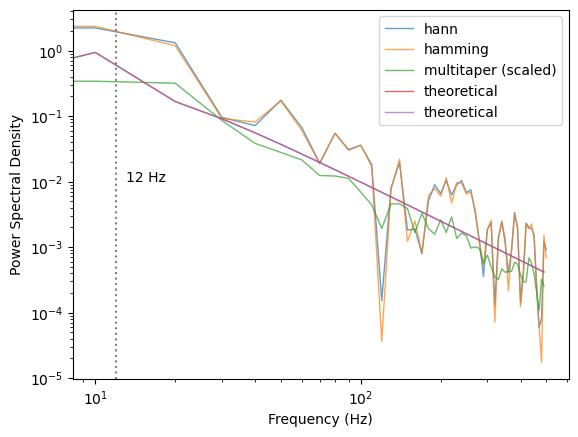

In [12]:
# Plotting...

freq_hann, psd_hann = single_taper_psd(signal, 'hann')
freq_hamming, psd_hamming = single_taper_psd(signal, 'hamming')
freq_mt, psd_mt = multitaper_psd(signal)

plt.loglog(freq_hann, psd_hann, linewidth=1, alpha=0.7, label='hann')
plt.loglog(freq_hamming, psd_hamming, linewidth=1, alpha=0.7, label='hamming')
plt.loglog(freq_mt, psd_mt, linewidth=1, alpha=0.7, label='multitaper (scaled)')
plt.plot(fd.frequencies, fd.combined_spectrum, linewidth=1, alpha=0.7, label='theoretical')
plt.plot(fd.frequencies, fd.combined_spectrum, linewidth=1, alpha=0.7, label='theoretical')

plt.axvline(x=12, color='gray', linestyle=':', linewidth=1.5)
plt.text(13, 0.01,'12 Hz')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.legend()
plt.show()

In [13]:
print(len(freq_hann))

51


In [14]:
print(len(freq_hamming))

51


In [15]:
print(len(freq_mt))

50


In [16]:
print(len(fd.frequencies))

50


In [17]:
# Calculate Bias

def calc_mean_bias(empiricalPSD, theoreticalPSD):
    N = len(theoreticalPSD)
    empiricalPSD = empiricalPSD[:-1] if (len(empiricalPSD) > N) else empiricalPSD
    biases = empiricalPSD - theoreticalPSD # do we need to change this cuz the empirical length is 251 while theoretical length is 250
    meanBias = np.sum(biases)/N

    return meanBias

In [18]:
# Taper Comparison

#print(freq_hann)
#print(fd.frequencies)

# Bias
hannBias = calc_mean_bias(psd_hann, fd.combined_spectrum)
hammingBias = calc_mean_bias(psd_hamming, fd.combined_spectrum)
mtBias = calc_mean_bias(psd_mt, fd.combined_spectrum)

print(f"Hann Bias: {hannBias}")
print(f"Hamming Bias: {hammingBias}")
print(f"Multitaper Bias: {mtBias}")

Hann Bias: 0.07192029255671423
Hamming Bias: 0.06856964873867472
Multitaper Bias: 0.0017163726276958763
